# LLM.

啟動互動式分割系統：
  - 使用 YOLO 模型對輸入圖像進行分割
  - 分割後將結果存成 txt 檔，再由 Ollama 的 Llama3.2 分析圖片中共有多少個物件


請輸入圖檔路徑 (或輸入 'exit' 結束):  img.png
請輸入命令 (例如 '分割'):  對這張圖片做分割


開始對圖像進行分割：img.png

image 1/1 C:\Users\koala\img.png: 320x640 4 persons, 209.3ms
Speed: 31.1ms preprocess, 209.3ms inference, 36.4ms postprocess per image at shape (1, 3, 320, 640)
分割完成，結果圖檔儲存在: annotated_img.png
檢測結果已存入: detections_img.txt
Llama3.2 回應：
根據圖像檢測結果，總共有4個物件被識別為人類。


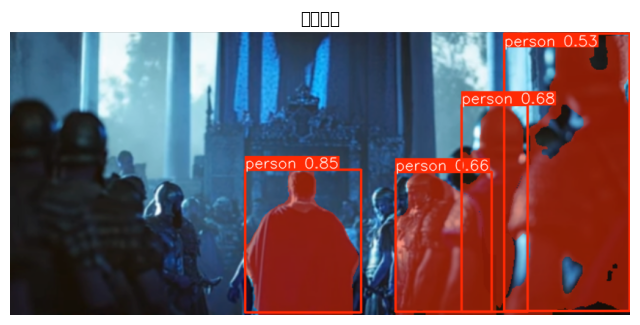

請輸入圖檔路徑 (或輸入 'exit' 結束):  img2.png
請輸入命令 (例如 '分割'):  幫我做分割計算


開始對圖像進行分割：img2.png

image 1/1 C:\Users\koala\img2.png: 480x640 2 persons, 2 ties, 224.1ms
Speed: 0.0ms preprocess, 224.1ms inference, 8.9ms postprocess per image at shape (1, 3, 480, 640)
分割完成，結果圖檔儲存在: annotated_img2.png
檢測結果已存入: detections_img2.txt
Llama3.2 回應：
根據檔案內容，這張圖片中總共有 4 個物件。


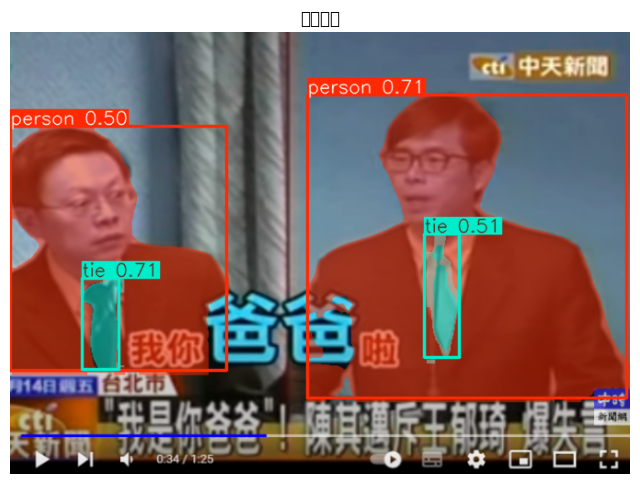

請輸入圖檔路徑 (或輸入 'exit' 結束):  exit


結束程式。


In [2]:
import os
import subprocess
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2

def query_llama(prompt):
    """
    使用 Ollama 的 Llama3.2 模型透過 CLI 進行查詢。
    指定 encoding 為 "utf-8"，以避免 Windows 預設 cp950 解碼錯誤。
    使用命令：ollama run llama3.2 "你的 prompt"
    """
    try:
        result = subprocess.run(
            ["ollama", "run", "llama3.2", prompt],
            capture_output=True,
            text=True,
            encoding="utf-8",  # 指定使用 utf-8 編碼
            check=True
        )
        # 如果 stdout 為 None，則回傳空字串，否則進行 strip()
        if result.stdout is not None:
            return result.stdout.strip()
        else:
            return ""
    except subprocess.CalledProcessError as e:
        return f"查詢 Llama 時發生錯誤: {e}"

def segment_image_yolo(image_path, yolo_model):
    """
    使用 YOLO segmentation 模型對圖像進行分割預測，
    回傳該圖像的預測結果物件。
    """
    print(f"開始對圖像進行分割：{image_path}")
    results = yolo_model.predict(source=image_path, conf=0.5, show=False)
    return results[0]

def interactive_loop(yolo_model):
    """
    互動式介面：
      1. 請使用者輸入圖檔路徑 (或輸入 'exit' 結束)；
      2. 請使用者輸入命令（例如 '分割'）；
      3. 若命令包含「分割」則：
         - 使用 YOLO 模型對圖像進行分割預測，
         - 儲存帶有分割註記的圖像，
         - 將檢測結果轉成文字後存入 txt 檔，
         - 讀取 txt 檔內容並組成 prompt 送給 Llama3.2 分析圖片中共有多少個物件，
         - 並顯示 Llama 的回應與圖像結果。
    """
    while True:
        image_path = input("請輸入圖檔路徑 (或輸入 'exit' 結束): ").strip()
        if image_path.lower() == "exit":
            print("結束程式。")
            break
        if not os.path.exists(image_path):
            print("圖檔不存在，請重新輸入。")
            continue

        command = input("請輸入命令 (例如 '分割'): ").strip()
        if "分割" in command:
            # 1. 使用 YOLO 模型對圖像進行分割預測
            seg_result = segment_image_yolo(image_path, yolo_model)
            
            # 2. 取得註記後的圖像（RGB 格式），並儲存結果圖檔
            annotated_img = seg_result.plot()
            output_img_path = os.path.join(os.path.dirname(image_path), "annotated_" + os.path.basename(image_path))
            cv2.imwrite(output_img_path, cv2.cvtColor(annotated_img, cv2.COLOR_RGB2BGR))
            print(f"分割完成，結果圖檔儲存在: {output_img_path}")
            
            # 3. 產生檢測結果的文字內容（以 bounding box 資訊為例）
            detections_str = ""
            if seg_result.boxes is not None:
                for i, box in enumerate(seg_result.boxes.data.tolist()):
                    class_id = int(box[5])
                    class_name = seg_result.names[class_id]
                    confidence = box[4]
                    bbox = box[:4]
                    detections_str += f"物件 {i+1}: {class_name}, 信心: {confidence:.2f}, bbox: {bbox}\n"
            else:
                detections_str = "無檢測結果\n"
            
            # 4. 將檢測結果寫入 txt 檔案
            base_name = os.path.splitext(os.path.basename(image_path))[0]
            txt_path = os.path.join(os.path.dirname(image_path), f"detections_{base_name}.txt")
            with open(txt_path, "w", encoding="utf-8") as f:
                f.write("圖像檢測結果：\n")
                f.write(detections_str)
            print(f"檢測結果已存入: {txt_path}")

            # 5. 讀取 txt 檔內容，組成 prompt 送給 Llama3.2 分析圖片中物件總數
            with open(txt_path, "r", encoding="utf-8") as f:
                txt_content = f.read()
            prompt = (
                f"請根據以下檔案內容，告訴我這張圖片中總共有多少個物件？\n\n{txt_content}"
            )
            llama_response = query_llama(prompt)
            print("Llama3.2 回應：")
            print(llama_response)
            
            # 6. 顯示註記後的圖像
            plt.figure(figsize=(8, 6))
            plt.imshow(annotated_img)
            plt.title("分割結果")
            plt.axis("off")
            plt.show()
        else:
            print("目前僅支援 '分割' 命令，請重新輸入。")

if __name__ == "__main__":
    # 請確認 YOLO segmentation 模型檔案存在，並修改成你的模型路徑
    model_path = "yolov8n-seg.pt"
    yolo_model = YOLO(model_path)
    
    print("啟動互動式分割系統：")
    print("  - 使用 YOLO 模型對輸入圖像進行分割")
    print("  - 分割後將結果存成 txt 檔，再由 Ollama 的 Llama3.2 分析圖片中共有多少個物件")
    
    interactive_loop(yolo_model)
